<div style="text-align: right">ADEC7430 Lecture 2</div>
<div style="text-align: right">Prof. Stefano Parravano, 09/02/2025</div>

## OLS: Different Perspective

In [4]:
import torch

ModuleNotFoundError: No module named 'torch'

### Problem 1 Solution

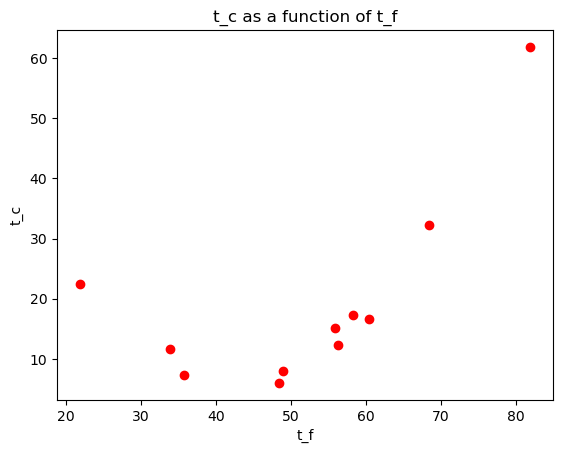

In [5]:
import numpy as np
import matplotlib.pyplot as plt

t_c = np.array([7.3, 15.1, 17.2, 61.9, 12.3, 8.0, 11.6, 22.5, 6.0, 16.6, 32.2])
t_f = np.array([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

plt.plot(t_f, t_c, "ro")
plt.title("t_c as a function of t_f")
plt.xlabel("t_f")
plt.ylabel("t_c")
plt.show()

A quadratic realtionship seems plausible here. At this point we should also recall that a univariate quadratic function (univariate here because we have one feature) has the form : 

$$ f(x) = ax^2 + bx + c $$  
where:  
$$ (a,b,c) \in \mathbf{R}$$  
and of course let's not forget:  
$$ a \neq 0 $$  

In the context of our problem here we can write the following:  

$$ t_p = ax^2 + bx + c $$  
where we think of $t_p$ as the predicted value of $t_t$ for some input $t_f$.  

If we are interested in fitting a curve between our points we can think of defining our standard loss function as:  

$$ L =\frac {1}{N} \sum_{i=1}^n(\overline{Y_i} - Y_i)^2 $$  

We can replace key vaiables of this Standard loss function with those that are specific to our problem:
$$ L =\frac {1}{N} \sum_{}(t_p - t_c)^2 $$  
we can follow this with another round of substitutions:    
$$ L =\frac {1}{N} \sum_{}((ax^2 + bx + c) - t_c)^2 $$  
To enable an easy walkthough of the gradient math that we need to perform, I will 'split' our loss function into smaller parts by writing it as the composition of smaller (easier) functions.  
Let:
$$ m = ax^2 + bx + c - t_c $$  
we can $\therefore$ write $L$ as:    
$$ L = \frac {1}{N} \sum_{}m^2 $$  

Suddendly L is an extremely nice looking function that we will be able to differentiate without any problems. Before we start computing any derivatives we need to take stock of what paramters our model will have. It should be clear that we will have 3 trainable paramters: $a$,$b$,$c$. The gradient of $L$ , keeping in mind the chain rule can be written as:  
$$ \nabla_{a,b,c} L = \langle \frac{\partial L}{\partial m} \frac{\partial m}{\partial a}, \frac{\partial L}{\partial m} \frac{\partial m}{\partial b}, \frac{\partial L}{\partial m} \frac{\partial m}{\partial c} \rangle $$  

Our job now is to compute each of the partials in the expressions above. Don't let the notation fool you, this is a very simple problem, and is suprisingly elementary from a mathematical standpoint.  

$$ \frac{\partial L}{\partial m}= \frac{1}{n} \cdot 2m $$
$$ \frac{\partial m}{\partial a}= {t_f}^2 $$
$$ \frac{\partial m}{\partial b}= t_f $$
$$ \frac{\partial m}{\partial c}= 1 $$  

$$ \nabla_{a,b,c} L = \langle \frac{1}{n}\cdot 2m({t_f}^2), \frac{1}{n}(2m) \cdot t_f,\frac{1}{n}(2m)\rangle $$  

We can now convert this into code and use gradient descent to compute the optimal paramters a,b,c that will define our functional mapping of the experimental data we have.  
Note: I have dropped the sigma to make the notation easier. We compute values for the gradient for each sample, thereby generating a gradient vector for each compnent listed above. We then sum each component vector to generate three real numbers. We then 'nudge' each paramter using these three scalars.

In [11]:
import numpy as np

def model(t_f, a, b, c):
    return a * t_f**2 + b * t_f + c
    
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()
#we can take the derivative of our loss function. Note this is where we substituded and made L= m^2
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c)
    return dsq_diffs

# Since t_p = model(a, b,c), the derivatives of t_p with respect to a,b  and c are given by:
def dmodel_da(t_f, a, b, c):
    return t_f**2

def dmodel_db(t_f, a, b, c):
    return t_f

def dmodel_dc(t_f, a, b, c):
    return np.ones_like(t_f)

# ---- gradients wrt parameters (chain rule glued together) ----
def grad_fn(t_f, t_c, t_p, a, b, c):
    dL_dt = 2 * (t_p - t_c)                 # dloss_fn(t_p, t_c)
    da = np.mean(dL_dt * (t_f**2))          # dmodel_da = t_f**2
    db = np.mean(dL_dt * (t_f))             # dmodel_db = t_f
    dc = np.mean(dL_dt * np.ones_like(t_f)) # dmodel_dc = 1
    return np.array([da, db, dc], dtype=float)

# ---- training loop (vectorized over data; loops only over epochs) ----
def training_loop(n_epochs, learning_rate, params, t_f, t_c, print_params=True):
    params = np.array(params, dtype=float)  # ensure float array [a, b, c]
    loss_values, epoch_list = [], []

    for epoch in range(1, n_epochs + 1):
        a, b, c = params

        # forward pass
        t_p = a * (t_f**2) + b * t_f + c

        # loss (MSE)
        loss = np.mean((t_p - t_c)**2)

        # backward pass (gradients)
        grads = grad_fn(t_f, t_c, t_p, a, b, c)

        # gradient descent update
        params = params - learning_rate * grads

        # bookkeeping
        loss_values.append(float(loss))
        epoch_list.append(epoch)

        # progress printing: first 2 epochs, then every 4000
        if print_params and (epoch <= 2 or epoch % 4000 == 0):
            print(f"Epoch {epoch}, Loss {float(loss):.6f}")
            # uncomment for debugging:
            # print("Grads:", grads, "Params:", params)

        # safety check to stop if loss blows up
        if not np.isfinite(loss):
            print("Stopping: non-finite loss encountered.")
            break

    loss_history = list(zip(epoch_list, loss_values))
    return params, loss_history

We are ready to find our optimal paramters a,b,c via gradient descent.  
Let's normalize our inputs and then start **training**.

In [12]:
def normalize_tensor_0_1(tensor):
    min_ten=min(tensor)
    max_ten=max(tensor)
    norm_ten=(tensor - min_ten)/(max_ten-min_ten)
    return(norm_ten)
def reverse_normalize_tensor_0_1(tensor,norm_tensor):
    min_ten=min(tensor)
    max_ten=max(tensor)
    ten=norm_tensor*(max_ten-min_ten)+min_ten
    return(ten)

We can start training !

In [13]:
import random
random.uniform(0, 1)
a,b,c = random.uniform(0, 1),random.uniform(0, 1),random.uniform(0, 1)
print('Initial values for parameters (a,b,c)=:',a,b,c)
tf_normalized = normalize_tensor_0_1(t_f)
import time
start_time=time.time()
params,loss_history = training_loop(
    n_epochs = 100_000, 
    learning_rate = 1e-2, 
    params = np.array([a,b,c]), 
    t_f = tf_normalized, 
    t_c = t_c,
    print_params = False)
end_time=time.time()
total_train_time=end_time-start_time
print('Total train time:',total_train_time)
#let's make our predictions and then inverser the normalization

Initial values for parameters (a,b,c)=: 0.5529063820960228 0.8588657012217096 0.640182631662593
Total train time: 18.06047224998474


In [14]:
print(f"{a},{b},{c}")
print(params)

0.5529063820960228,0.8588657012217096,0.640182631662593
[130.69740223 -90.7816476   22.58458673]


We can visualize our resutls now..  
 1. We first will make predictions using the model we just trained (remember to use normalized values for the predictor)  
 2. We will create a zipped list of t_p and t_f and sort by t_f (this will enable us to draw a nice line graph)
 3. We will plot our results and perform some very basic error disgnostics.  
 

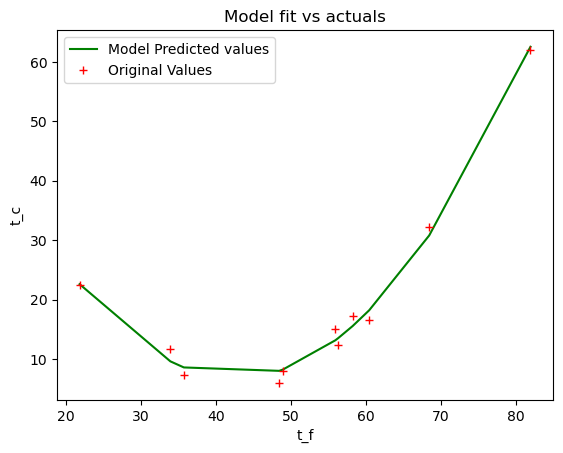

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# assume you already have:
# t_f (np.array), t_c (np.array), tf_normalized (np.array), params (np.array [a,b,c])

# 1) predict on normalized inputs
t_p1 = model(tf_normalized, *params)  # -> predicted Celsius

# 2) sort by original t_f for a smooth line
order = np.argsort(t_f)
t_f_sort = t_f[order]
t_p1_sort = t_p1[order]

# 3) plot
plt.title('Model fit vs actuals')
plt.xlabel('t_f')
plt.ylabel('t_c')
plt.plot(t_f_sort, t_p1_sort, 'g', label='Model Predicted values')  # line
plt.plot(t_f, t_c, 'r+', label='Original Values')                   # points
plt.legend()
plt.show()

In [17]:
for x in range(len(t_p1)):
    print(f"Predicted value: {t_p1[x]}, Actual value: {t_c[x]}, Input value: {t_f[x]}")

Predicted value: 8.579632285352364, Actual value: 7.3, Input value: 35.7
Predicted value: 13.151453897743448, Actual value: 15.1, Input value: 55.9
Predicted value: 15.544536038718821, Actual value: 17.2, Input value: 58.2
Predicted value: 62.50034136123671, Actual value: 61.9, Input value: 81.9
Predicted value: 13.540142165194094, Actual value: 12.3, Input value: 56.3
Predicted value: 8.22374661835281, Actual value: 8.0, Input value: 48.9
Predicted value: 9.605133381213275, Actual value: 11.6, Input value: 33.9
Predicted value: 22.584586730804627, Actual value: 22.5, Input value: 21.8
Predicted value: 8.007457975881529, Actual value: 6.0, Input value: 48.4
Predicted value: 18.1917939152189, Actual value: 16.6, Input value: 60.4
Predicted value: 30.77081036176474, Actual value: 32.2, Input value: 68.4


In [19]:
from sympy import *
residual_vector = Matrix(t_c - t_p1)
residual_vector.norm()

4.76615176760448

In [20]:
def rmse_error(actuals,predicted):
    error=[x-y for x,y in zip(actuals,predicted)]
    sq_error=[x*x for x in error]
    sum_sq_error=sum(sq_error)
    mse = sum_sq_error/len(sq_error)
    rmse = mse**0.5
    return(rmse)

def mape_error(actuals,predicted):
    error=[x-y for x,y in zip(actuals,predicted)]
    relative_error=[x/y for x,y in zip(error,actuals)]
    abs_relative_error=[abs(x) for x in relative_error]
    sum_abs_rel_error=sum(abs_relative_error)
    mape=(sum_abs_rel_error/len(actuals))*100
    return(mape)

In [21]:
rmse=rmse_error(t_c,t_p1)
print('On average our preidctions were off by +/-',rmse,'units')

mape=mape_error(t_c,t_p1)
print('On average our preidctions were off by +/-',mape,'percent')

On average our preidctions were off by +/- 1.4370488279121127 units
On average our preidctions were off by +/- 10.815065630354068 percent


The error metrics confirm what we seen in the plot. This function that we found via gradient descent does in fact fit our data pretty well.